In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as pl
import pooch

from pathlib import Path

In [2]:
if Path("cache/tut_preproc.h5ad").exists():
    adata = sc.read_h5ad("cache/tut_preproc.h5ad")

In [3]:
# normalization

# Saving count data -> raw counts should be preserved for violin plots, etc..
adata.layers["counts"] = adata.X.copy() 

# Normalizing to median total counts
sc.pp.normalize_total(adata)

# Logarithmize the data
sc.pp.log1p(adata)

In [8]:
# feature selection

sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor = "seurat", batch_key="sample")

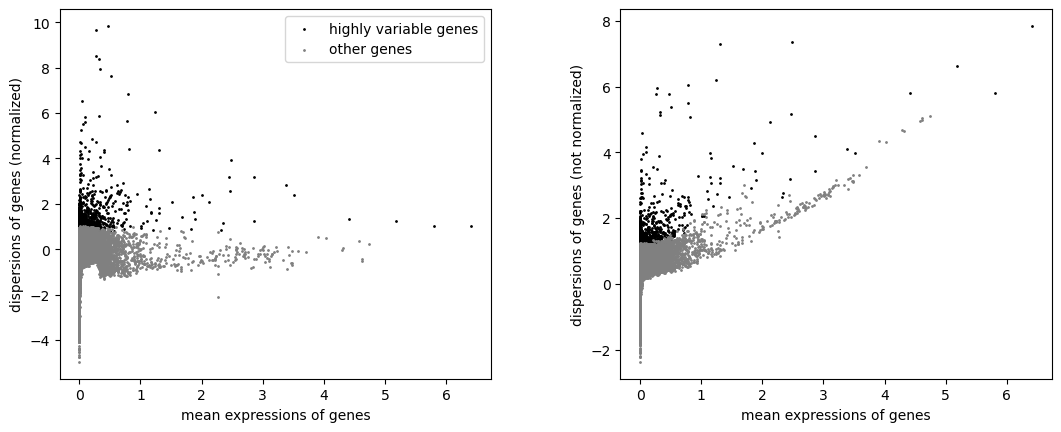

In [9]:
sc.pl.highly_variable_genes(adata)

In [10]:
adata.write("cache/tut_preproc.h5ad")

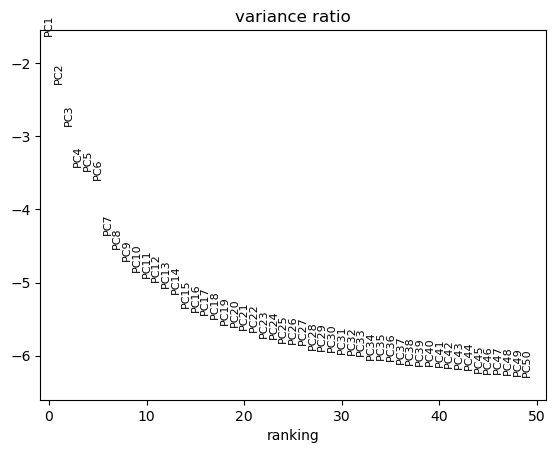

In [12]:
# dimensionality reduction

sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs = 50, log = True)

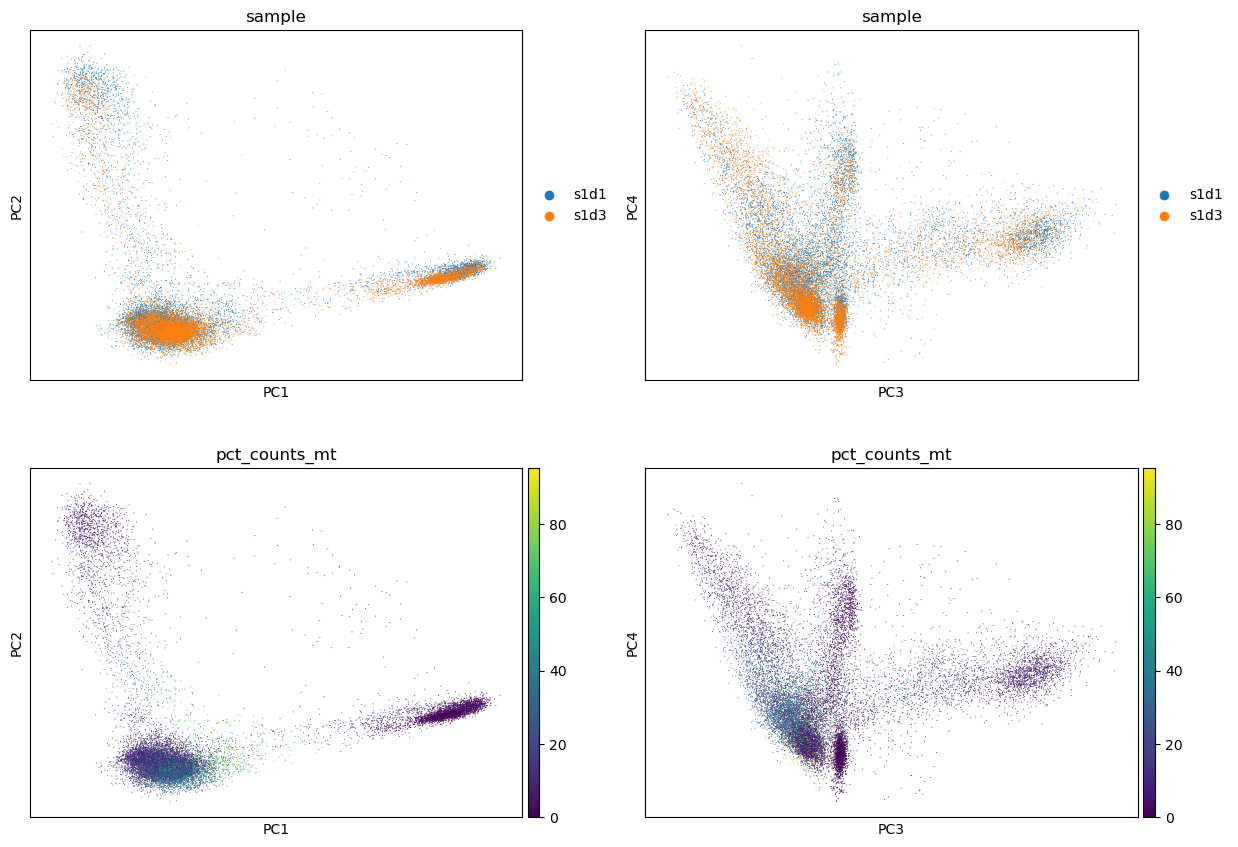

In [13]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [ ]:
### out of tutorial : 데이터에 mt gene이 너무 많아 regress out 해야 하는데 함수가 안돌아감

In [3]:
## regress_out 돌릴 때 코드가 계속 터졌음.

## 1) pct_counts_mt가 존재하고 numeric한지 확인 

'pct_counts_mt' in adata.obs
np.isfinite(adata.obs['pct_counts_mt']).all()

## 2) dtype이 int가 아니라 float32가 되어야 함 (Regression과 PCA는 실수 연산임)
## float64는 float32의 2배 메모리. 다량의 데이터를 다루는 scanpy + numba는 float32기반
adata.obs['pct_counts_mt'].dtype

dtype('float32')

In [9]:
## 3) 메모리 초과일수도 있으므로 HVG에서만 작업

adata = adata[:, adata.var['highly_variable']].copy()

## 4) contiguous하게 만든다. 
adata.X = np.ascontiguousarray(adata.X)

## data slicing 할때 noncontiguous하게 됨 (메모리상의 위치와 matrix상의 위치가 불연속적)

In [10]:
sc.pp.regress_out(
    adata,
    keys=['pct_counts_mt'],
    ##chunked=True,            # process genes in blocks
    ##chunk_size=2000,         # tune down if RAM is low
    ### 해당 2개는 현재 버전에서 지원하지 않으므로..
    n_jobs=8                 # or fewer if you prefer
)

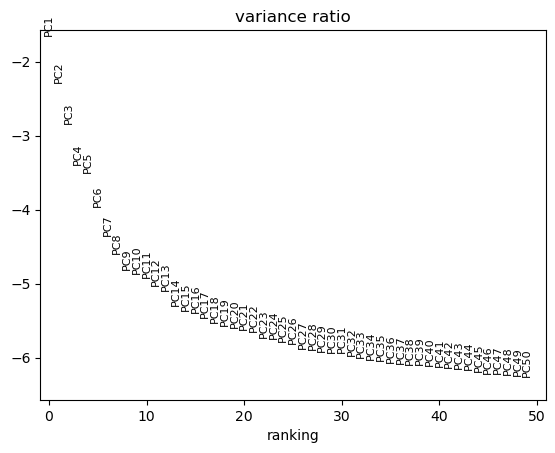

In [11]:
# 데이터를 재가공했으므로 다시 차원축소

sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs = 50, log = True)

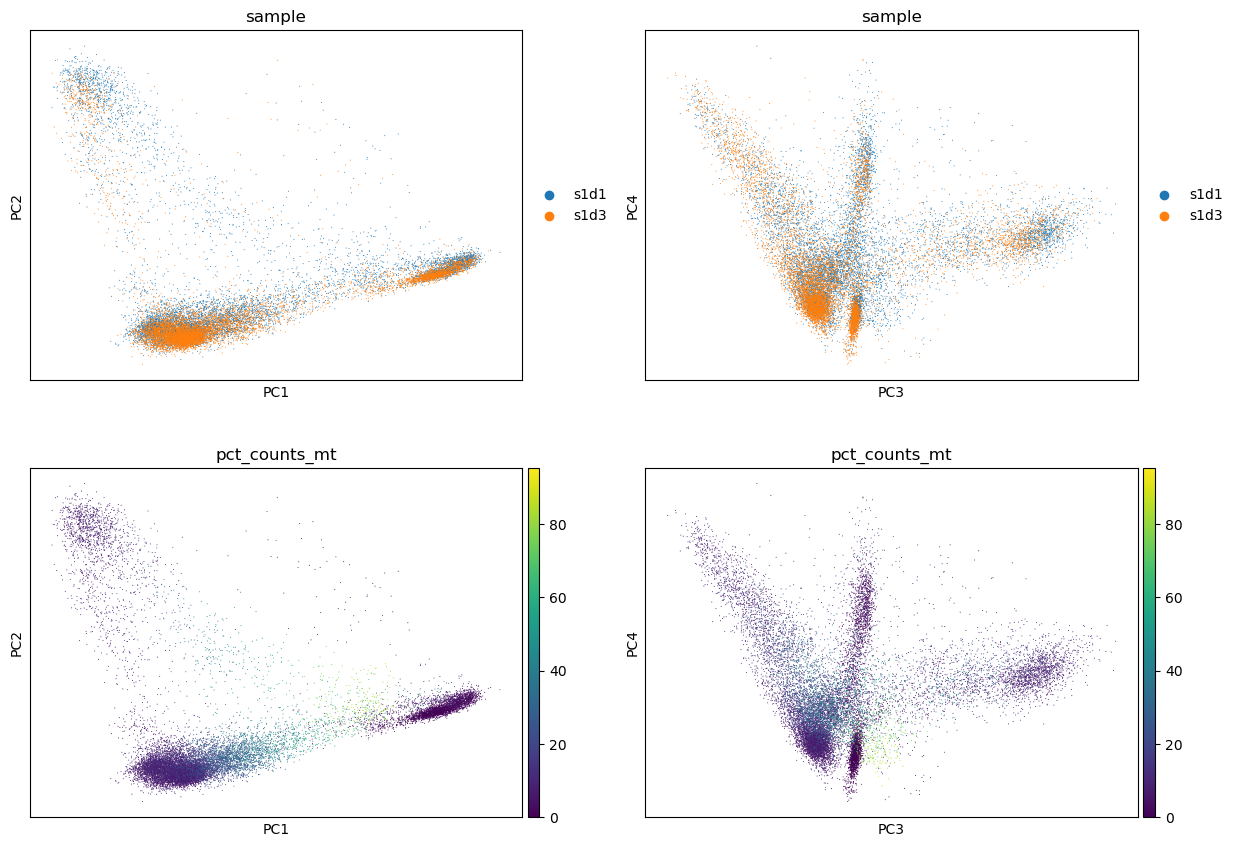

In [12]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)
## mt gene의 영향이 확연히 줄었음을 볼 수 있다. 

In [13]:
adata.write("cache/tut_preproc.h5ad")